In [190]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [191]:
df = pd.read_csv("data/updated_data.csv")

df = df.iloc[:, 1:]

/var/folders/r6/j2xslqfj0lg0bxy1nj8b6fzm0000gn/T/ipykernel_12492/4080523743.py:1: DtypeWarning: Columns (5,79,80) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/updated_data.csv")


In [192]:
df.columns

Index(['BuyerAgentAOR', 'ListAgentAOR', 'Flooring', 'ViewYN', 'WaterfrontYN',
       'BasementYN', 'PoolPrivateYN', 'OriginalListPrice', 'ListingKey',
       'ListAgentEmail', 'CloseDate', 'ClosePrice', 'ListAgentFirstName',
       'ListAgentLastName', 'Latitude', 'Longitude', 'UnparsedAddress',
       'PropertyType', 'LivingArea', 'ListPrice', 'DaysOnMarket',
       'ListOfficeName', 'BuyerOfficeName', 'CoListOfficeName',
       'ListAgentFullName', 'CoListAgentFirstName', 'CoListAgentLastName',
       'BuyerAgentMlsId', 'BuyerAgentFirstName', 'BuyerAgentLastName',
       'FireplacesTotal', 'AssociationFeeFrequency', 'AboveGradeFinishedArea',
       'ListingKeyNumeric', 'MLSAreaMajor', 'TaxAnnualAmount',
       'CountyOrParish', 'MlsStatus', 'ElementarySchool', 'AttachedGarageYN',
       'ParkingTotal', 'BuilderName', 'PropertySubType', 'LotSizeAcres',
       'SubdivisionName', 'BuyerOfficeAOR', 'YearBuilt', 'StreetNumberNumeric',
       'ListingId', 'BathroomsTotalInteger', 'City', '

In [193]:
df['Stories'].isna().sum()

16153

In [194]:
columns = ['PostalCode', 'PoolPrivateYN', 'ViewYN', 'AttachedGarageYN', 'BasementYN', 'FireplaceYN', 
           'WaterfrontYN', 'DaysOnMarket', 'BedroomsTotal','BathroomsTotalInteger', 'YearBuilt', 'LivingArea',
            'ElementarySchool', 'ElementarySchoolDistrict', 'MiddleOrJuniorSchool', 'MiddleOrJuniorSchoolDistrict', 
            'HighSchool', 'HighSchoolDistrict', 'ClosePrice', 'mean_zhi', 'median_sale_price', 'Stories']
df = df[columns]

In [195]:
df.shape[0]

110533

In [196]:
df.isna().sum()

PostalCode                           0
PoolPrivateYN                    12486
ViewYN                            9917
AttachedGarageYN                 12329
BasementYN                      107795
FireplaceYN                         65
WaterfrontYN                    110500
DaysOnMarket                         0
BedroomsTotal                        0
BathroomsTotalInteger               20
YearBuilt                           82
LivingArea                          57
ElementarySchool                 94558
ElementarySchoolDistrict        110533
MiddleOrJuniorSchool             94430
MiddleOrJuniorSchoolDistrict    110533
HighSchool                       89689
HighSchoolDistrict               28009
ClosePrice                           2
mean_zhi                           846
median_sale_price                  983
Stories                          16153
dtype: int64

In [197]:
# def fill_missing(df):
#     output = df.copy()
#     def mean_impute_numerical(col):
#         return col.fillna(col.mean())
    
#     def median_impute(col):
#         median = col.median()
#         return col.fillna(median)
    
#     # impute these values based on the mean value of postal code
#     for col in ['BathroomsTotalInteger', 'YearBuilt', 'LivingArea']:
#         new_col = output.groupby('PostalCode')[col].transform(mean_impute_numerical)
#         output[col] = new_col

#     # if percentage of True is above 0.5, fill in missing values with True, else False
#     def mean_impute_TF(col):
#         if col.mean() > 0.5:
#             return col.fillna(True)
#         return col.fillna(False)
    
#     # use above function to impute
#     for col in ['PoolPrivateYN', 'ViewYN', 'AttachedGarageYN']:
#         new_col = output.groupby('PostalCode')[col].transform(mean_impute_TF)
#         output[col] = new_col

#     # fill in other missing values for homes that are in their only zip code
#     for col in ['BathroomsTotalInteger', 'YearBuilt', 'LivingArea']:
#         output[col] = mean_impute_numerical(output[col])
#     for col in ['PoolPrivateYN', 'ViewYN', 'AttachedGarageYN']:
#         output[col] = mean_impute_TF(output[col])

#     # fill in missing values for monthly zestimates with median
#     for col in ['January', 'median_sale_price']:
#         output[col] = median_impute(output[col])
        
#     output = output.dropna(subset=['ClosePrice']) # drop where ClosePrice is missing
    
#     return output

In [198]:
def fill_missing(df):
    output = df.copy()
    def mean_impute_numerical(col):
        return col.fillna(col.mean())
    
    def median_impute(col):
        median = col.median()
        return col.fillna(median)
    
    # impute these values based on the mean value of postal code
    for col in ['BathroomsTotalInteger', 'YearBuilt', 'LivingArea', 'BedroomsTotal']:
        new_col = output.groupby('PostalCode')[col].transform(mean_impute_numerical)
        output[col] = new_col

    # fill in other missing values for homes that are in their only zip code
    for col in ['BathroomsTotalInteger', 'YearBuilt', 'LivingArea', 'BedroomsTotal']:
        output[col] = mean_impute_numerical(output[col])

    # fill in missing values for monthly zestimates with median
    for col in ['mean_zhi', 'median_sale_price']:
        output[col] = median_impute(output[col])
    
    output['Stories'] = mean_impute_numerical(output['Stories'])
    output = output.dropna(subset=['ClosePrice']) # drop where ClosePrice is missing
    
    return output

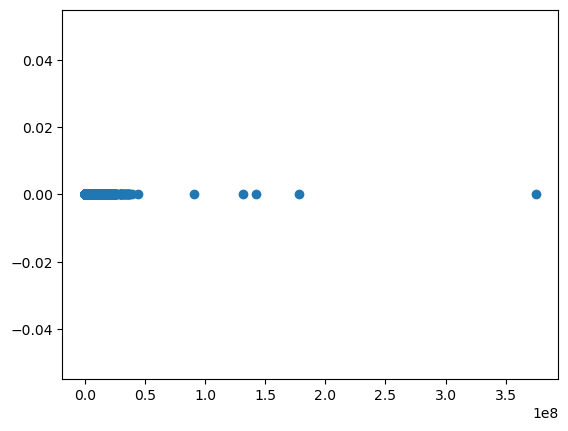

In [199]:
plt.scatter(df['ClosePrice'], [0] * df['ClosePrice'].shape[0])

In [200]:
def drop_outliers(df):
    copy = df.copy()
    iqr = np.percentile(df['ClosePrice'], 75) - np.percentile(df['ClosePrice'], 25)
    print(copy.shape[0])
    high_cutoff = df['ClosePrice'].median() + 1.5 * iqr
    low_cutoff = 50000
    print(f'high_cutoff: {high_cutoff}, low_cutoff: {low_cutoff}')
    copy = copy[(copy['ClosePrice'] < high_cutoff) & (copy['ClosePrice'] > low_cutoff)]
    print(copy.shape[0])
    return copy

In [201]:
def engineer_schools(df):
    copy = df.copy()
    # no need for elementary school district or middle school district because all values in those are missing
    cols = ['ElementarySchool', 'MiddleOrJuniorSchool', 'HighSchool', 'HighSchoolDistrict']
    sum = pd.Series(np.zeros(df.shape[0]), index=df.index)
    for col in cols:
        sum += (1- copy[col].isna())
    copy['total_schools'] = sum
    copy = copy.drop(columns=['ElementarySchool', 'ElementarySchoolDistrict','MiddleOrJuniorSchool', 
                              'MiddleOrJuniorSchoolDistrict', 'HighSchool', 'HighSchoolDistrict'])
    return copy

In [202]:
df['ClosePrice']

0         3000000.0
1         7750000.0
2          575000.0
3         1810000.0
4         1135000.0
            ...    
110528     650000.0
110529     275000.0
110530    2225000.0
110531    3737500.0
110532     375000.0
Name: ClosePrice, Length: 110533, dtype: float64

In [203]:
def numerate_features(df):
    output = df.copy()
    extra_features = ['PoolPrivateYN', 'ViewYN', 'AttachedGarageYN', 'BasementYN', 'FireplaceYN', 'WaterfrontYN']
    for col in extra_features:
        output[col] = output[col].fillna(0).astype(int)
    output['extra_features'] = output[extra_features].sum(axis=1)
    output = output.drop(columns=extra_features)
    return output

def engineer_postal_code(df):
    copy = df.copy()
    def cut_off(value):
        if len(value) > 5:
            return int(value[:5]) # if the postal code is in the form XXXXX-XXXX, cut off the second part
        return int(value)
    copy.dropna(subset=['PostalCode'], inplace=True)
    copy['PostalCode'] = copy['PostalCode'].astype(str)
    copy['PostalCode'] = copy['PostalCode'].transform(cut_off)
    return copy

def log_scale(df, columns):
    copy = df.copy()
    for col in columns:
        copy[col] = np.log1p(df[col])
    return copy

In [204]:
def preprocess(df):
    output = df.copy()
    output = fill_missing(output)
    output = engineer_schools(output)
    output = numerate_features(output)
    output = engineer_postal_code(output)
    output = drop_outliers(output)
    output = log_scale(output, ['mean_zhi', 'median_sale_price', 'ClosePrice'])
    return output

In [205]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

import kerastuner as kt

In [206]:
target = "ClosePrice"  # Replace with actual target column name
cleaned_df = preprocess(df)
display(cleaned_df)
cleaned_df.isna().sum()

110531
high_cutoff: 2130000.0, low_cutoff: 50000
97280


,PostalCode,DaysOnMarket,BedroomsTotal,BathroomsTotalInteger,YearBuilt,LivingArea,ClosePrice,mean_zhi,median_sale_price,Stories,total_schools,extra_features
2,93906,0,2.0,1.0,1950.0,863.0,13.262127,13.468598,12.861001,1.35392,1.0,2
3,90046,0,3.0,1.0,1923.0,1338.0,14.408838,14.482931,14.053346,1.00000,0.0,1
4,92057,0,4.0,4.0,2009.0,3203.0,13.942144,13.654060,12.922084,2.00000,0.0,1
5,95119,0,4.0,2.0,1969.0,2013.0,14.217637,14.257074,13.603555,1.35392,1.0,2
6,90275,0,3.0,2.0,1959.0,1614.0,14.122996,14.474341,13.797857,1.00000,1.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
110525,95338,555,2.0,2.0,1991.0,1460.0,12.072547,12.856383,13.143148,1.00000,1.0,2
110526,95338,559,2.0,1.0,2001.0,747.0,12.594734,12.856383,13.143148,1.00000,2.0,2
110528,93669,527,2.0,2.0,1960.0,1044.0,13.384729,12.829608,12.442136,1.00000,4.0,3
110529,92325,592,2.0,1.0,1930.0,960.0,12.524530,12.861620,12.323860,1.00000,1.0,1


PostalCode               0
DaysOnMarket             0
BedroomsTotal            0
BathroomsTotalInteger    0
YearBuilt                0
LivingArea               0
ClosePrice               0
mean_zhi                 0
median_sale_price        0
Stories                  0
total_schools            0
extra_features           0
dtype: int64

In [207]:
final_features = ['DaysOnMarket', 'BedroomsTotal', 'BathroomsTotalInteger', 'YearBuilt', 
                  'LivingArea', 'total_schools', 'Stories', 'extra_features', 'mean_zhi', 'median_sale_price']

X = cleaned_df[final_features]
y = cleaned_df['ClosePrice']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [208]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [209]:
def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))  # Residual sum of squares
    mean_y = tf.reduce_mean(y_true)
    ss_tot = tf.reduce_sum(tf.square(y_true - mean_y))  # Total sum of squares
    return 1 - (ss_res / (ss_tot + tf.keras.backend.epsilon()))  # Avoid division by zero

In [210]:
# def build_model(hp):
#     model = Sequential()
    
#     # Input layer with tunable number of neurons
#     model.add(Dense(
#         units=hp.Int('units_input', min_value=8, max_value=64, step=8),
#         activation='relu',
#         input_shape=(X_train.shape[1],)
#     ))

#     # Hidden layers with tunable parameters
#     for i in range(hp.Int("num_layers", 2, 5)):  # Tune between 2 to 5 hidden layers
#         model.add(Dense(
#             units=hp.Int(f'units_{i}', min_value=16, max_value=64, step=16),
#             activation='relu'
#         ))
#         if hp.Boolean(f'batch_norm_{i}'):  # Optionally add BatchNormalization
#             model.add(BatchNormalization())

#         if hp.Boolean(f'dropout_{i}'):  # Optionally add Dropout
#             model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', 0.1, 0.5, step=0.1)))

#     # Output layer (regression - no activation)
#     model.add(Dense(1))

#     # Compile model with tunable learning rate
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(
#             learning_rate=hp.Choice('learning_rate', [0.001, 0.005, 0.01])
#         ),
#         loss='mae',
#         metrics=['mae', r2_score]
#     )
    
#     return model

# tuner = kt.BayesianOptimization(
#     build_model,
#     objective="val_mae",  # Optimizing for Mean Absolute Error (MAE) for regression
#     max_trials=10,  # Number of different hyperparameter sets to try
#     executions_per_trial=1,  # Number of models trained per trial
#     directory="bayesian_tuning",
#     project_name="regression_model"
# )

# tuner.search(X_train, y_train, 
#              epochs=60, 
#              validation_data=(X_test, y_test), 
#              batch_size=32)

# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# best_model = tuner.hypermodel.build(best_hps)

In [211]:
# optimizer = Adam(learning_rate=0.001)
# best_model.compile(loss='mae', metrics=['mae', r2_score, mape_loss])
# history = best_model.fit(X_train, y_train, 
#                          epochs=60, 
#                          validation_data=(X_test, y_test), 
#                          batch_size=32)

# loss, mae, r2, mape = best_model.evaluate(X_test, y_test)
# print(f"Final MAE: {mae:.2f}")
# print(f"Final R²: {r2:.2f}")
# print(f"Final MAPE: {mape:.2f}")

(array([   36.,    72.,   174.,   596.,  2512.,  9867., 20649., 29299.,
        20272., 13803.]),
 array([10.82974842, 11.20393678, 11.57812515, 11.95231351, 12.32650188,
        12.70069024, 13.07487861, 13.44906697, 13.82325534, 14.1974437 ,
        14.57163207]),
 <BarContainer object of 10 artists>)

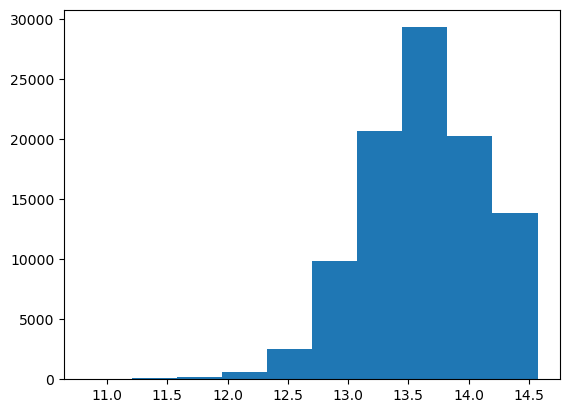

In [212]:
plt.hist(cleaned_df['ClosePrice'])

Epoch 1/60


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2432/2432 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1.9605 - mae: 1.9605 - r2_score: -62.5955 - val_loss: 0.1768 - val_mae: 0.1768 - val_r2_score: 0.7623
Epoch 2/60
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 2s 810us/step - loss: 0.1935 - mae: 0.1935 - r2_score: 0.7194 - val_loss: 0.1554 - val_mae: 0.1554 - val_r2_score: 0.8157
Epoch 3/60
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 2s 800us/step - loss: 0.1682 - mae: 0.1682 - r2_score: 0.7798 - val_loss: 0.1454 - val_mae: 0.1454 - val_r2_score: 0.8337
Epoch 4/60
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 2s 768us/step - loss: 0.1595 - mae: 0.1595 - r2_score: 0.7999 - val_loss: 0.1583 - val_mae: 0.1583 - val_r2_score: 0.8012
Epoch 5/60
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 2s 753us/step - loss: 0.1562 - mae: 0.1562 - r2_score: 0.8052 - val_loss: 0.1414 - val_mae: 0.1414 - val_r2_score: 0.8366
Epoch 6/60
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 2s 781us/step - loss: 0.1576 - mae: 0.1576 - r2_score: 0.8020 - val_loss: 0.1507 - val_mae: 0.1507 - val_r2_score: 0.8158
Epoch 7/60
2432/2432 ━━━━━━

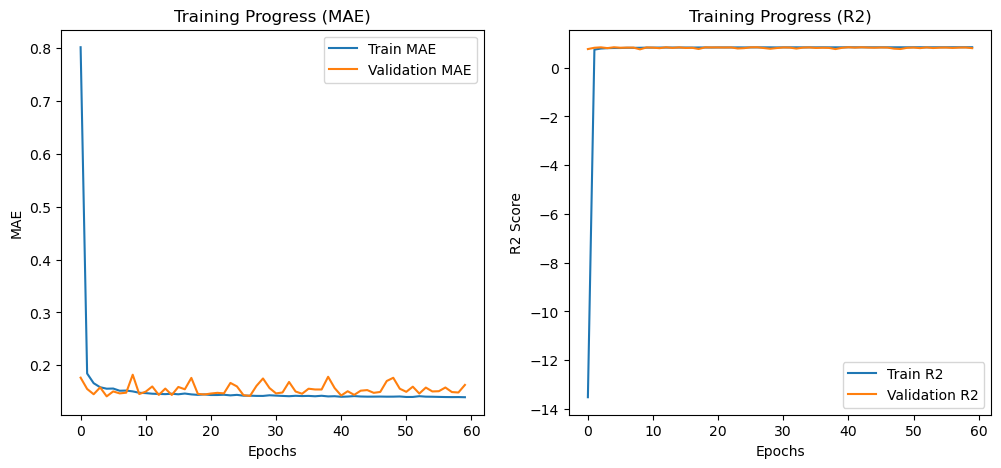

In [213]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # No activation for regression
])

# Compile model with R² and MAE
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae', metrics=['mae', r2_score])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=60, batch_size=32, verbose=1)

# Evaluate
loss, mae, r2 = model.evaluate(X_test, y_test)
predictions = np.expm1(model.predict(X_test)).ravel()
actual = np.expm1(y_test).to_numpy()
real_mae = np.abs(actual - predictions).mean()
mape = np.abs((actual - predictions) / actual).mean() * 100

print(f"Final MAE: {real_mae}")
print(f"Final R2: {r2:.2f}")
print(f"Final MAPE: {mape:.2f}")

# Plot MAE & R²
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training Progress (MAE)')

plt.subplot(1, 2, 2)
plt.plot(history.history['r2_score'], label='Train R2')
plt.plot(history.history['val_r2_score'], label='Validation R2')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.legend()
plt.title('Training Progress (R2)')

plt.show()
